In [177]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

from skimage.measure import label

# define a grid to interpolation profiles to

zhgts = 250. + 250.*np.arange(60)

_nthreads = 2
percent = (50,90,95)

#---------------------------------------------------------------------
def interp3dz_np(data, z3d, z1d, nthreads = _nthreads):
    
    dinterp = np.zeros((len(z1d),data.shape[1]),dtype=np.float32)

    if nthreads < 0:  # turning this off for now.
        def worker(j):
            print("running %d %s" % (i, data.shape))
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        pool = mp.Pool(nthreads)
        for i in np.arange(data.shape[2]):
            pool.apply_async(worker, args = (i, ))
        pool.close()
        pool.join()
        
        return dinterp
    
    else:        
        for j in np.arange(data.shape[1]):
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        return dinterp



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
def generate_ideal_profiles(run_dir, model_type='wrf', w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None):
    
    print("processing model run:  %s \n" % run_dir)
    
    if model_type == 'wrf':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['Time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,  "wrfout*")

        w    = ds.W.values
        w    = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])

        dbz  = ds.REFL_10CM.values
        pres = ds.P.values
        z    = ds.PHB.values/9.806
        z    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix, percentiles=percentiles)
        
        ds.close()

        return profiles
    
    if model_type == 'fv3':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,   "*.nc")

        w    = ds.W.values
        w    = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])
        dbz  = ds.REFL_10CM.values
        pres = ds.P.values
        z    = ds.PHB.values/9.806
        z    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix, percentiles=percentiles)
        
        ds.close()

        return profiles
    
    if model_type == 'cm1':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, parallel=True)
    
        ds = open_mfdataset_list(run_dir,  "cm1out_0000*.nc")

        w    = ds.winterp.values
        dbz  = ds.dbz.values
        pres = ds.prs.values
        z    = ds.zh.values * 1000. # heights are in km
        z3d  = np.broadcast_to(z[np.newaxis, :, np.newaxis, np.newaxis], w.shape)

        profiles = compute_obj_profiles(w, dbz, pres, z3d, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix, percentiles=percentiles)
        
        ds.close()

        return profiles

#-------------------------------------------------------------------------------
def compute_obj_profiles(W, DBZ, PRES, Z, w_thresh = 5.0, cref_thresh = 45., min_pix=5, percentiles=None):
   
    # thanks to Larissa Reames for suggestions on how to do this (and figuring out what to do!)
    
    mask_cref   = np.where(DBZ.max(axis=1) > cref_thresh, True, False)
    mask_w_3d   = np.where(PRES < 70000.0, W, np.nan)
    mask_w_2d   = np.nanmax(mask_w_3d, axis=1)
    mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
    f_mask      = mask_w_cref.astype(np.int8)
        
    wlist   = [] 
    all_obj = 0
    w_obj   = 0
    
    for n in np.arange(W.shape[0]): # loop over number of time steps.            
        
        # check to see if there are objects
        
        if (np.sum(f_mask[n]) == 0):
            
            continue

        else:
        
            label_array, num_obj = label(f_mask[n], background=0, connectivity=2, return_num = True) # returns a 2D array of labels for updrafts)
            
            all_obj += num_obj

            if( num_obj > 0 ):                                     # if there is more than the background object, process array.

                for l in np.arange(1,num_obj):                       # this is just a list of 1,2,3,4.....23,24,25....
                    npix = np.sum(label_array == l)                # this is a size check - number of pixels assocated with a label
                    if npix >= min_pix:
                        jloc, iloc = np.where(label_array == l)    # extract out the locations of the updrafts 
                        w_obj += 1
                        if len(iloc) > 0:
                            wraw    = W[n,:,jloc,iloc]               # get w_raw profiles
                            zraw    = Z[n,:,jloc,iloc]               # get z_raw profiles
                            
                            profile = interp3dz_np(wraw.transpose(), zraw.transpose(), zhgts, nthreads = _nthreads)

                            wlist.append([profile.mean(axis=1)],)
                            
#         if n == 15:
            
#             fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(30,10))
#             ax[0].imshow(DBZ[n].max(axis=0))
#             ax[1].imshow(W[n].max(axis=0))
#             ax[2].imshow(f_mask[n])
#             ax[3].imshow(label_array)


                            
    if( len(wlist) < 1 ):
        
        print("\n ---> Compute_Obj_Profiles found no objects...returning zero...\n")
        return np.zeros((zhgts.shape[0],1))
    
    else:
        
        wprofiles = np.squeeze(np.asarray(wlist), axis=1).transpose()

        print("\n Number of selected updraft profiles:  %d \n Number of labeled objects:  %d\n" % (w_obj, all_obj))
        
        if percentiles:
            
            wprofiles = np.sort(wprofiles, axis=1)
                       
            wprofile_percentiles = [wprofiles]
            
            for n, p in enumerate(percentiles):
                
                print("Percentile value:  %f\n" % p)
                
                idx = max(int(wprofiles.shape[1]*p/100.) - 1, 0)
                
                wprofile_percentiles.append(wprofiles[:,idx:])
            
            return wprofile_percentiles
            
        else:
    
            return np.sort(wprofiles, axis=1)
    
    

In [189]:
w_thresh = 5.0
cref_thresh = 45.
percent = (50,90,95)

# CM1

input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'

cm1_q11 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q11_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
cm1_q12 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q12_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
cm1_q13 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q13_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
cm1_q14 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q14_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
cm1_q15 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q15_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
cm1_q16 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q16_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

# # WRF ######

# in_dir  = "/scratch/larissa.reames/ideal_updrafts"
# out_dir = "/work/wicker/CAM_analysis_tools"
# shear   = "shallow_12.5"

wrf_q11  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_qv11", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
wrf_q12  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_qv12", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
wrf_q13  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_qv13", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
wrf_q14  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_qv14", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
wrf_q15  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_qv15", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
wrf_q16  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_qv16", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

fv3_q11  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_dt20_hord6_q11", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
fv3_q12  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_dt20_hord6_q12", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
fv3_q13  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_dt20_hord6_q13", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
fv3_q14  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_dt20_hord6_q14", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
fv3_q15  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_dt20_hord6_q15", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
fv3_q16  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_dt20_hord6_q16", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)





processing model run:  /scratch/wicker/cm1r20.3/run/squall_q11_s12 


 Number of selected updraft profiles:  66 
 Number of labeled objects:  87

Percentile value:  50.000000

Percentile value:  90.000000

Percentile value:  95.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_q12_s12 


 Number of selected updraft profiles:  234 
 Number of labeled objects:  256

Percentile value:  50.000000

Percentile value:  90.000000

Percentile value:  95.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_q13_s12 


 Number of selected updraft profiles:  428 
 Number of labeled objects:  450

Percentile value:  50.000000

Percentile value:  90.000000

Percentile value:  95.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_q14_s12 


 Number of selected updraft profiles:  485 
 Number of labeled objects:  508

Percentile value:  50.000000

Percentile value:  90.000000

Percentile value:  95.000000

processing model run:  /scratch/wicker/cm1r20.3/ru

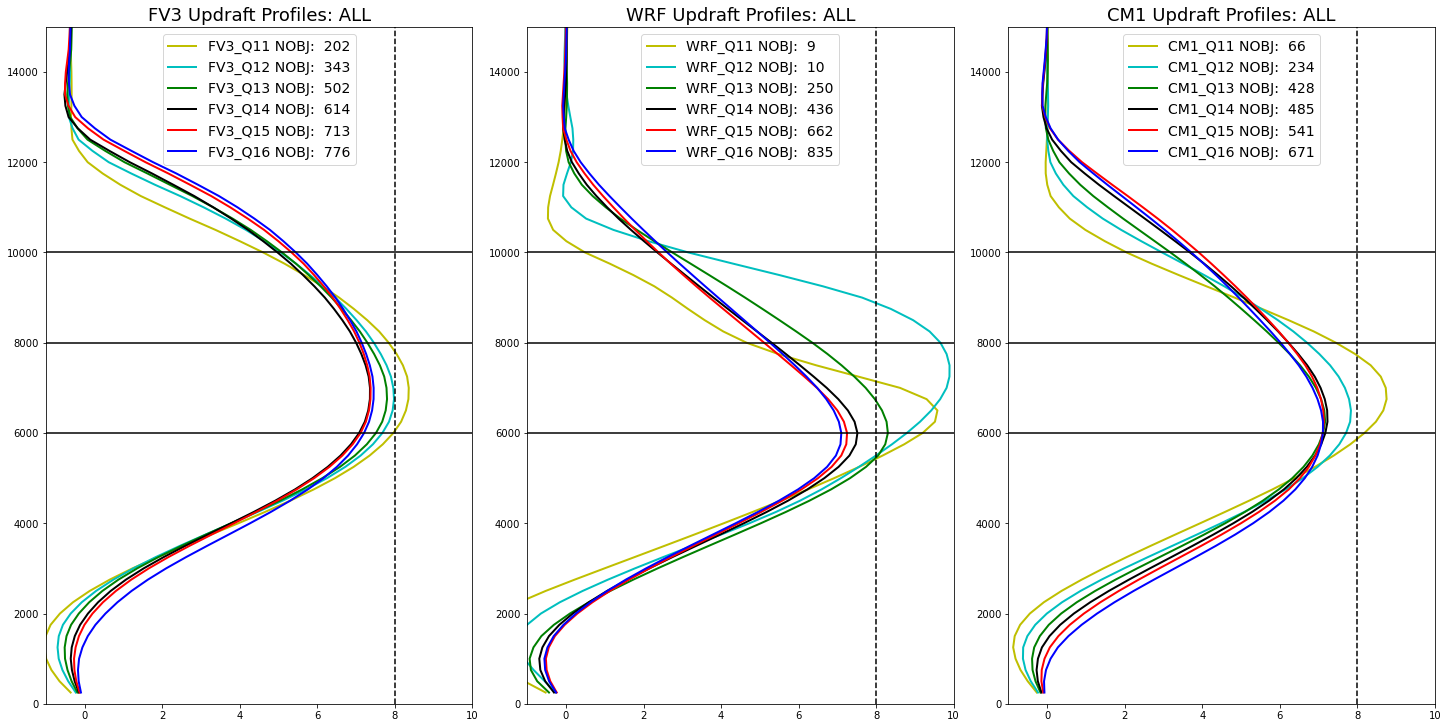

In [223]:
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
    
fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

percent = 0

plot_wprofile(fv3_q11, zhgts, percent, ax[0], 'y', 'FV3_Q11')
plot_wprofile(fv3_q12, zhgts, percent, ax[0], 'c', 'FV3_Q12')
plot_wprofile(fv3_q13, zhgts, percent, ax[0], 'g', 'FV3_Q13')
plot_wprofile(fv3_q14, zhgts, percent, ax[0], 'k', 'FV3_Q14')
plot_wprofile(fv3_q15, zhgts, percent, ax[0], 'r', 'FV3_Q15')
plot_wprofile(fv3_q16, zhgts, percent, ax[0], 'b', 'FV3_Q16')
ax[0].set_title("FV3 Updraft Profiles: ALL", fontsize=18)
ax[0].axhline(y=6000., color='k', linestyle='-')
ax[0].axhline(y=8000., color='k', linestyle='-')
ax[0].axhline(y=10000., color='k', linestyle='-')
ax[0].axvline(x=8., color='k', linestyle='--')


plot_wprofile(wrf_q11, zhgts, percent, ax[1], 'y', 'WRF_Q11')
plot_wprofile(wrf_q12, zhgts, percent, ax[1], 'c', 'WRF_Q12')
plot_wprofile(wrf_q13, zhgts, percent, ax[1], 'g', 'WRF_Q13')
plot_wprofile(wrf_q14, zhgts, percent, ax[1], 'k', 'WRF_Q14')
plot_wprofile(wrf_q15, zhgts, percent, ax[1], 'r', 'WRF_Q15')
plot_wprofile(wrf_q16, zhgts, percent, ax[1], 'b', 'WRF_Q16')
ax[1].set_title("WRF Updraft Profiles: ALL", fontsize=18)
ax[1].axhline(y=6000., color='k', linestyle='-')
ax[1].axhline(y=8000., color='k', linestyle='-')
ax[1].axhline(y=10000., color='k', linestyle='-')
ax[1].axvline(x=8., color='k', linestyle='--')

plot_wprofile(cm1_q11, zhgts, percent, ax[2], 'y', 'CM1_Q11')
plot_wprofile(cm1_q12, zhgts, percent, ax[2], 'c', 'CM1_Q12')
plot_wprofile(cm1_q13, zhgts, percent, ax[2], 'g', 'CM1_Q13')
plot_wprofile(cm1_q14, zhgts, percent, ax[2], 'k', 'CM1_Q14')
plot_wprofile(cm1_q15, zhgts, percent, ax[2], 'r', 'CM1_Q15')
plot_wprofile(cm1_q16, zhgts, percent, ax[2], 'b', 'CM1_Q16')
ax[2].set_title("CM1 Updraft Profiles: ALL", fontsize=18)
ax[2].axhline(y=6000., color='k', linestyle='-')
ax[2].axhline(y=8000., color='k', linestyle='-')
ax[2].axhline(y=10000., color='k', linestyle='-')
ax[2].axvline(x=8., color='k', linestyle='--')


ax[0].set_ylim(0.0,15000.)
ax[0].set_xlim(-1.0,10.0)
ax[0].legend(fontsize=14)
ax[1].set_ylim(0.0,15000.)
ax[1].set_xlim(-1.0,10.0)
ax[1].legend(fontsize=14)

ax[2].set_ylim(0.0,15000.)
ax[2].set_xlim(-1.0,10.0)
ax[2].legend(fontsize=14)


plt.show()

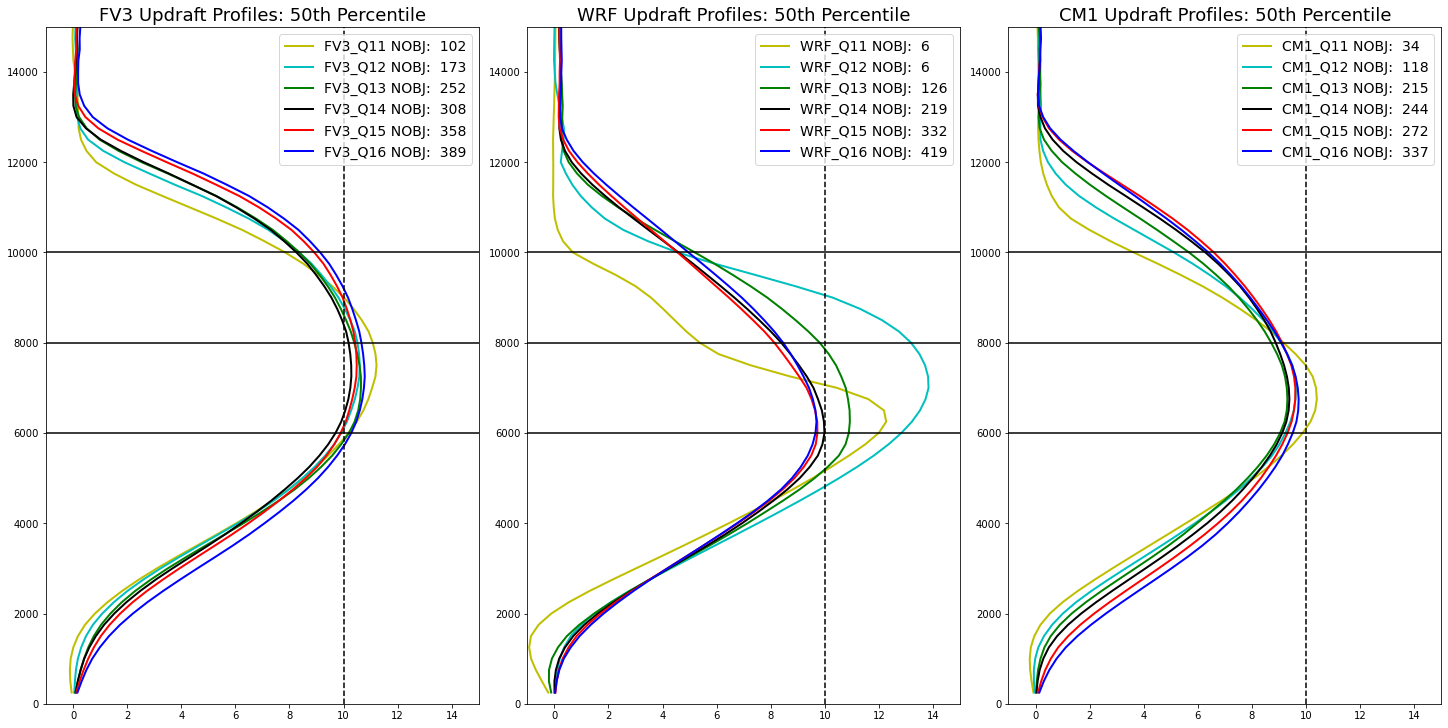

In [222]:
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
    
fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

percent = 1

plot_wprofile(fv3_q11, zhgts, percent, ax[0], 'y', 'FV3_Q11')
plot_wprofile(fv3_q12, zhgts, percent, ax[0], 'c', 'FV3_Q12')
plot_wprofile(fv3_q13, zhgts, percent, ax[0], 'g', 'FV3_Q13')
plot_wprofile(fv3_q14, zhgts, percent, ax[0], 'k', 'FV3_Q14')
plot_wprofile(fv3_q15, zhgts, percent, ax[0], 'r', 'FV3_Q15')
plot_wprofile(fv3_q16, zhgts, percent, ax[0], 'b', 'FV3_Q16')
ax[0].set_title("FV3 Updraft Profiles: 50th Percentile", fontsize=18)
ax[0].axhline(y=6000., color='k', linestyle='-')
ax[0].axhline(y=8000., color='k', linestyle='-')
ax[0].axhline(y=10000., color='k', linestyle='-')
ax[0].axvline(x=10., color='k', linestyle='--')

plot_wprofile(wrf_q11, zhgts, percent, ax[1], 'y', 'WRF_Q11')
plot_wprofile(wrf_q12, zhgts, percent, ax[1], 'c', 'WRF_Q12')
plot_wprofile(wrf_q13, zhgts, percent, ax[1], 'g', 'WRF_Q13')
plot_wprofile(wrf_q14, zhgts, percent, ax[1], 'k', 'WRF_Q14')
plot_wprofile(wrf_q15, zhgts, percent, ax[1], 'r', 'WRF_Q15')
plot_wprofile(wrf_q16, zhgts, percent, ax[1], 'b', 'WRF_Q16')
ax[1].set_title("WRF Updraft Profiles: 50th Percentile", fontsize=18)
ax[1].axhline(y=6000., color='k', linestyle='-')
ax[1].axhline(y=8000., color='k', linestyle='-')
ax[1].axhline(y=10000., color='k', linestyle='-')
ax[1].axvline(x=10., color='k', linestyle='--')

plot_wprofile(cm1_q11, zhgts, percent, ax[2], 'y', 'CM1_Q11')
plot_wprofile(cm1_q12, zhgts, percent, ax[2], 'c', 'CM1_Q12')
plot_wprofile(cm1_q13, zhgts, percent, ax[2], 'g', 'CM1_Q13')
plot_wprofile(cm1_q14, zhgts, percent, ax[2], 'k', 'CM1_Q14')
plot_wprofile(cm1_q15, zhgts, percent, ax[2], 'r', 'CM1_Q15')
plot_wprofile(cm1_q16, zhgts, percent, ax[2], 'b', 'CM1_Q16')
ax[2].set_title("CM1 Updraft Profiles: 50th Percentile", fontsize=18)
ax[2].axhline(y=6000., color='k', linestyle='-')
ax[2].axhline(y=8000., color='k', linestyle='-')
ax[2].axhline(y=10000., color='k', linestyle='-')
ax[2].axvline(x=10., color='k', linestyle='--')

ax[0].set_ylim(0.0,15000.)
ax[0].set_xlim(-1.0,15.0)
ax[0].legend(fontsize=14)
ax[1].set_ylim(0.0,15000.)
ax[1].set_xlim(-1.0,15.0)
ax[1].legend(fontsize=14)

ax[2].set_ylim(0.0,15000.)
ax[2].set_xlim(-1.0,15.0)
ax[2].legend(fontsize=14)


plt.show()

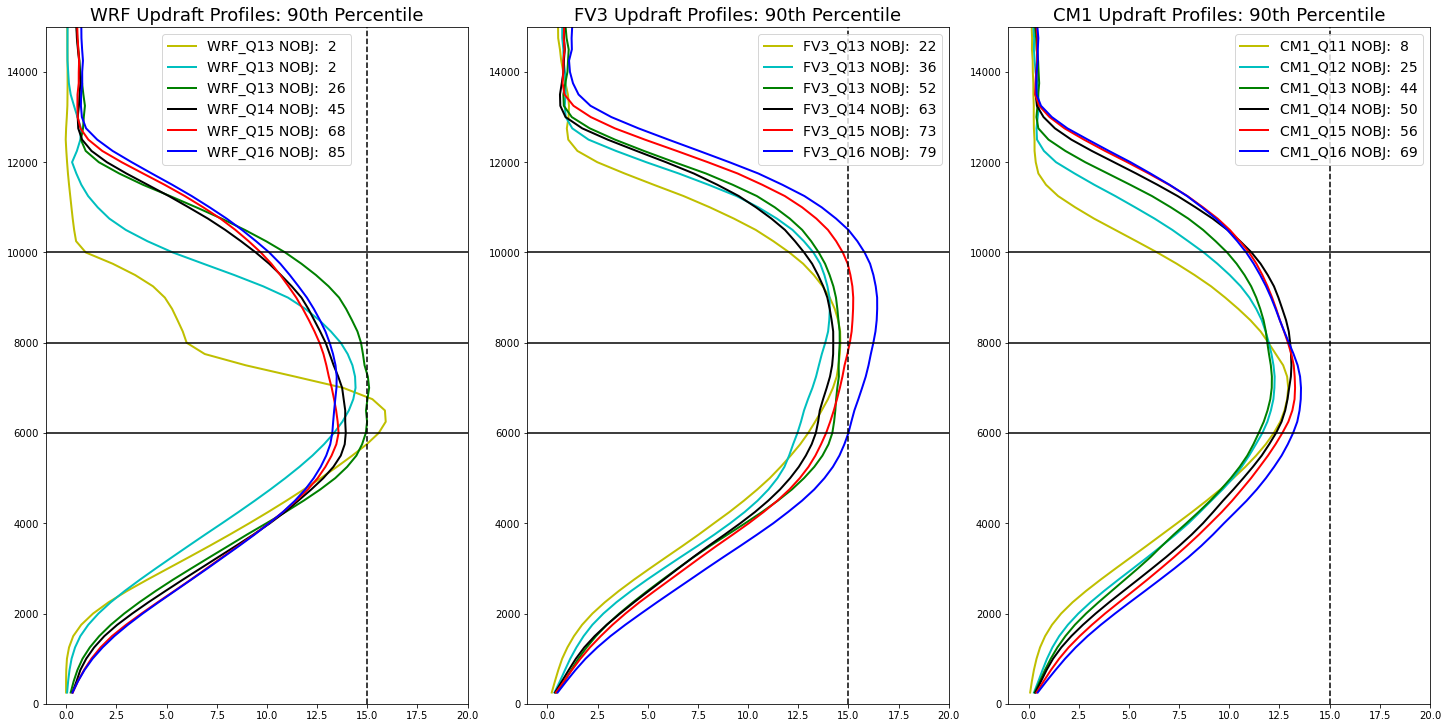

In [214]:
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
    
fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

percent = 2

plot_wprofile(wrf_q11, zhgts, percent, ax[0], 'y', 'WRF_Q13')
plot_wprofile(wrf_q12, zhgts, percent, ax[0], 'c', 'WRF_Q13')
plot_wprofile(wrf_q13, zhgts, percent, ax[0], 'g', 'WRF_Q13')
plot_wprofile(wrf_q14, zhgts, percent, ax[0], 'k', 'WRF_Q14')
plot_wprofile(wrf_q15, zhgts, percent, ax[0], 'r', 'WRF_Q15')
plot_wprofile(wrf_q16, zhgts, percent, ax[0], 'b', 'WRF_Q16')
ax[0].set_title("WRF Updraft Profiles: 90th Percentile", fontsize=18)

ax[0].axhline(y=6000., color='k', linestyle='-')
ax[0].axhline(y=8000., color='k', linestyle='-')
ax[0].axhline(y=10000., color='k', linestyle='-')
ax[0].axvline(x=15., color='k', linestyle='--')

plot_wprofile(fv3_q11, zhgts, percent, ax[1], 'y', 'FV3_Q13')
plot_wprofile(fv3_q12, zhgts, percent, ax[1], 'c', 'FV3_Q13')
plot_wprofile(fv3_q13, zhgts, percent, ax[1], 'g', 'FV3_Q13')
plot_wprofile(fv3_q14, zhgts, percent, ax[1], 'k', 'FV3_Q14')
plot_wprofile(fv3_q15, zhgts, percent, ax[1], 'r', 'FV3_Q15')
plot_wprofile(fv3_q16, zhgts, percent, ax[1], 'b', 'FV3_Q16')
ax[1].set_title("FV3 Updraft Profiles: 90th Percentile", fontsize=18)

ax[1].axhline(y=6000., color='k', linestyle='-')
ax[1].axhline(y=8000., color='k', linestyle='-')
ax[1].axhline(y=10000., color='k', linestyle='-')
ax[1].axvline(x=15., color='k', linestyle='--')

plot_wprofile(cm1_q11, zhgts, percent, ax[2], 'y', 'CM1_Q11')
plot_wprofile(cm1_q12, zhgts, percent, ax[2], 'c', 'CM1_Q12')
plot_wprofile(cm1_q13, zhgts, percent, ax[2], 'g', 'CM1_Q13')
plot_wprofile(cm1_q14, zhgts, percent, ax[2], 'k', 'CM1_Q14')
plot_wprofile(cm1_q15, zhgts, percent, ax[2], 'r', 'CM1_Q15')
plot_wprofile(cm1_q16, zhgts, percent, ax[2], 'b', 'CM1_Q16')
ax[2].set_title("CM1 Updraft Profiles: 90th Percentile", fontsize=18)
ax[2].axhline(y=6000., color='k', linestyle='-')
ax[2].axhline(y=8000., color='k', linestyle='-')
ax[2].axhline(y=10000., color='k', linestyle='-')
ax[2].axvline(x=15., color='k', linestyle='--')

ax[0].set_ylim(0.0,15000.)
ax[0].set_xlim(-1.0,20.)
ax[0].legend(fontsize=14)

ax[1].set_ylim(0.0,15000.)
ax[1].set_xlim(-1.0,20.)
ax[1].legend(fontsize=14)

ax[2].set_ylim(0.0,15000.)
ax[2].set_xlim(-1.0,20.)
ax[2].legend(fontsize=14)

plt.show()

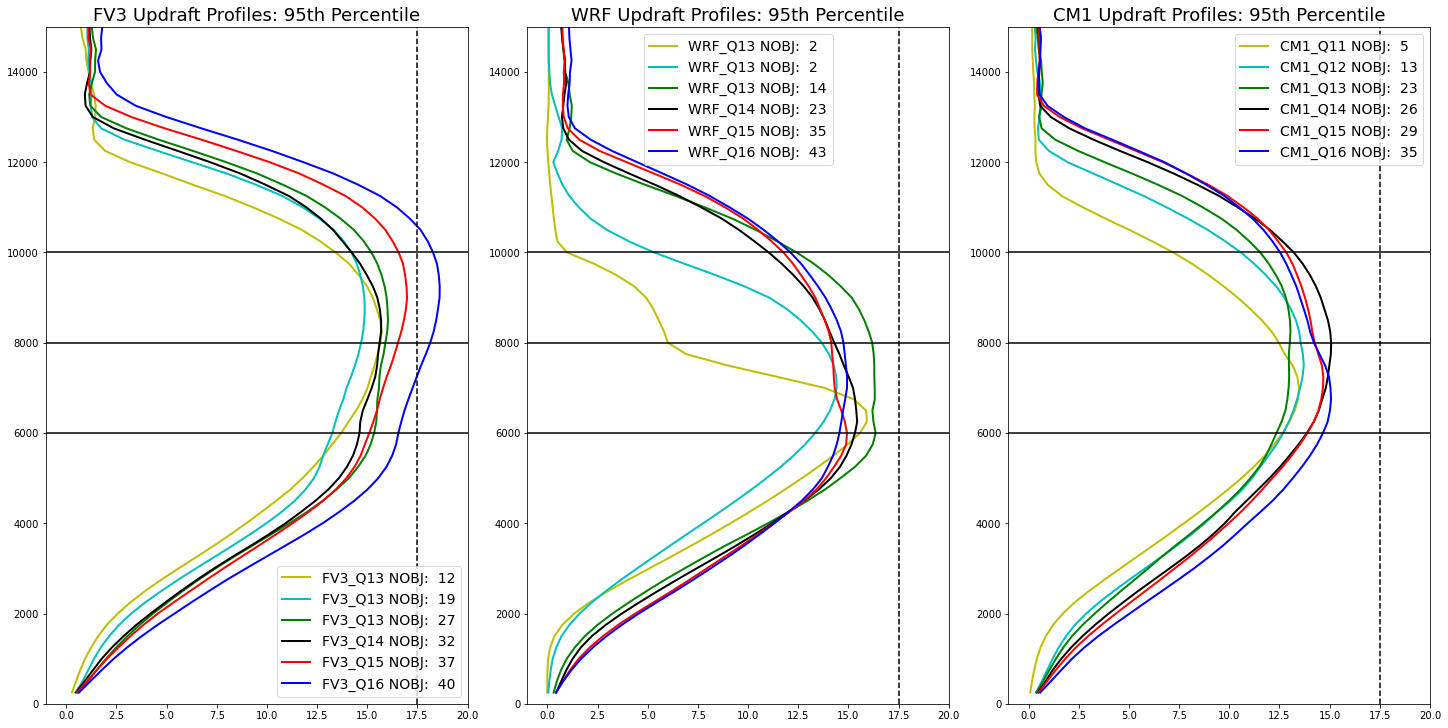

In [218]:
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
    
fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

percent = 3

plot_wprofile(fv3_q11, zhgts, percent, ax[0], 'y', 'FV3_Q13')
plot_wprofile(fv3_q12, zhgts, percent, ax[0], 'c', 'FV3_Q13')
plot_wprofile(fv3_q13, zhgts, percent, ax[0], 'g', 'FV3_Q13')
plot_wprofile(fv3_q14, zhgts, percent, ax[0], 'k', 'FV3_Q14')
plot_wprofile(fv3_q15, zhgts, percent, ax[0], 'r', 'FV3_Q15')
plot_wprofile(fv3_q16, zhgts, percent, ax[0], 'b', 'FV3_Q16')
ax[0].set_title("FV3 Updraft Profiles: 95th Percentile", fontsize=18)
ax[0].axhline(y=6000., color='k', linestyle='-')
ax[0].axhline(y=8000., color='k', linestyle='-')
ax[0].axhline(y=10000., color='k', linestyle='-')
ax[0].axvline(x=17.5, color='k', linestyle='--')

plot_wprofile(wrf_q11, zhgts, percent, ax[1], 'y', 'WRF_Q13')
plot_wprofile(wrf_q12, zhgts, percent, ax[1], 'c', 'WRF_Q13')
plot_wprofile(wrf_q13, zhgts, percent, ax[1], 'g', 'WRF_Q13')
plot_wprofile(wrf_q14, zhgts, percent, ax[1], 'k', 'WRF_Q14')
plot_wprofile(wrf_q15, zhgts, percent, ax[1], 'r', 'WRF_Q15')
plot_wprofile(wrf_q16, zhgts, percent, ax[1], 'b', 'WRF_Q16')
ax[1].set_title("WRF Updraft Profiles: 95th Percentile", fontsize=18)
ax[1].axhline(y=6000., color='k', linestyle='-')
ax[1].axhline(y=8000., color='k', linestyle='-')
ax[1].axhline(y=10000., color='k', linestyle='-')
ax[1].axvline(x=17.5, color='k', linestyle='--')

plot_wprofile(cm1_q11, zhgts, percent, ax[2], 'y', 'CM1_Q11')
plot_wprofile(cm1_q12, zhgts, percent, ax[2], 'c', 'CM1_Q12')
plot_wprofile(cm1_q13, zhgts, percent, ax[2], 'g', 'CM1_Q13')
plot_wprofile(cm1_q14, zhgts, percent, ax[2], 'k', 'CM1_Q14')
plot_wprofile(cm1_q15, zhgts, percent, ax[2], 'r', 'CM1_Q15')
plot_wprofile(cm1_q16, zhgts, percent, ax[2], 'b', 'CM1_Q16')
ax[2].set_title("CM1 Updraft Profiles: 95th Percentile", fontsize=18)
ax[2].axhline(y=6000., color='k', linestyle='-')
ax[2].axhline(y=8000., color='k', linestyle='-')
ax[2].axhline(y=10000., color='k', linestyle='-')
ax[2].axvline(x=17.5, color='k', linestyle='--')

ax[0].set_ylim(0.0,15000.)
ax[0].set_xlim(-1.0,20.0)
ax[0].legend(fontsize=14)

ax[1].set_ylim(0.0,15000.)
ax[1].set_xlim(-1.0,20.0)
ax[1].legend(fontsize=14)

ax[2].set_ylim(0.0,15000.)
ax[2].set_xlim(-1.0,20.0)
ax[2].legend(fontsize=14)

plt.show()